In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [9]:
from blackbox_wrapper import BlackboxWrapper
import keras
from datasets import build_coffee
from variational_autoencoder import load_model
from neighborhood_generators import NeighborhoodGenerator
from lore_wrapper import LoreWrapper
from utils import choose_z
from joblib import load
from lasts import load_multiple_lasts
import time
import numpy as np
from experiments_neighborhoods_surrogates import multiple_tests
from sbgdt import Sbgdt, generate_n_shapelets_per_size
from saxdt import Saxdt

In [5]:
random_state = 0
np.random.seed(random_state)
dataset_name = "coffee"
blackbox_name = "resnet"

file_path = parentdir + "/saved/" + dataset_name + "_" + blackbox_name + "_" + time.strftime("%Y%m%d_%H%M%S")

(X_train, y_train, X_val, y_val,
 X_test, y_test, X_exp_train, y_exp_train,
 X_exp_val, y_exp_val, X_exp_test, y_exp_test) = build_coffee(
    random_state = random_state
)

knn = load(parentdir + "/trained_models/coffee/coffee_knn.joblib")
resnet = keras.models.load_model(parentdir + "/trained_models/coffee/coffee_resnet.h5")

_, _, autoencoder = load_model(parentdir + "/trained_models/coffee/coffee_vae")

blackbox = BlackboxWrapper(knn, 2, 1)
encoder = autoencoder.layers[2]
decoder = autoencoder.layers[3]

DATASET INFO:
X SHAPE:  (28, 286, 1)
y SHAPE:  (28,)

CLASSES BALANCE
0 :  0.5
1 :  0.5

SHAPES:
BLACKBOX TRAINING SET:  (28, 286, 1)
BLACKBOX VALIDATION SET:  (0,)
BLACKBOX TEST SET:  (28, 286, 1)
EXPLANATION TRAINING SET:  (28, 286, 1)
EXPLANATION VALIDATION SET:  (0,)
EXPLANATION TEST SET:  (28, 286, 1)
Instructions for updating:
Colocations handled automatically by placer.


/Users/francesco/github/LASTS/datasets.py:521: UserWarning: The validation sets are empty, use cross-validation to evaluate models
  warnings.warn("The validation sets are empty, use cross-validation to evaluate models")
/Users/francesco/github/LASTS/datasets.py:522: UserWarning: Blackbox and Explanation sets are the same
  warnings.warn("Blackbox and Explanation sets are the same")


In [6]:
neighborhood_names = ["gaussian_matched", "uniform_sphere", "gaussian", "matched_uniform", "lore"]
neighborhood_list = [NeighborhoodGenerator, NeighborhoodGenerator, NeighborhoodGenerator, NeighborhoodGenerator, LoreWrapper]
neighborhood_kwargs_list = [
        {
            "n": 500,
            "n_search": 10000,
            "threshold": 2,
            "kind": "gaussian_matched",
            "sampling_kind": "gaussian_matched",
            "verbose": False,
            "redo_search": True,
            "forced_balance_ratio": 0.5,
            "cut_radius": False
        },
        {
            "n": 500,
            "n_search": 10000,
            "threshold": 2,
            "kind": "uniform_sphere",
            "sampling_kind": "uniform_sphere",
            "verbose": False,
            "redo_search": True,
            "forced_balance_ratio": 0.5,
            "cut_radius": True
        },
        {
            "n": 500,
            "n_search": 10000,
            "threshold": 2,
            "kind": "gaussian",
            "sampling_kind": "gaussian",
            "verbose": False,
            "redo_search": True,
            "forced_balance_ratio": 0.5,
            "cut_radius": False
        },
        {
            "n": 500,
            "n_search": 10000,
            "threshold": 2,
            "kind": "gaussian_matched",
            "sampling_kind": "uniform_sphere",
            "verbose": False,
            "redo_search": True,
            "forced_balance_ratio": 0.5,
            "cut_radius": True
        },
        {"verbose": False, "samples": 500, "ngen": 10}
    ]

In [23]:
n_shapelets_per_size = generate_n_shapelets_per_size(X_train.shape[1], n_shapelets_per_length=2, 
                                                     min_length=8, start_divider=2, divider_multiplier=1.35)
surrogate_kwargs_list = [{"shapelet_model_params": {"max_iter": 50, "n_shapelets_per_size":n_shapelets_per_size}, 
                          "random_state": random_state},
                             {"random_state": np.random.seed(0), "create_plotting_dictionaries":False}]

surrogate_list = [Sbgdt, Saxdt]
surrogate_names = ["stdt", "saxdt"]

Accuracy: 1.0 ± 0.0
1.0


NEIGHBORHOOD GENERATIONS



 1 / 100 

Binary sampling search:
   Testing threshold value: 2.0
   Testing threshold value: 1.0
   Best threshold found: 2.0
   Final counterfactual search... (this could take a while) Done!
Setting new threshold at radius: 1.4059891007650334

Sampling --> uniform_sphere
Forced balancing neighborhood... Done!

LABELS BALANCE
0 :  0.5
1 :  0.5

BINARY BALANCE
not-1 :  0.5
1 :  0.5


SURROGATE FITTING



 Surrogate sbgdt : 1 / 100 

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

 Surrogate saxdt : 1 / 100 



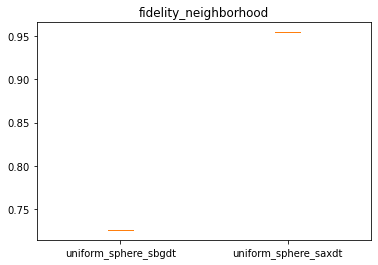

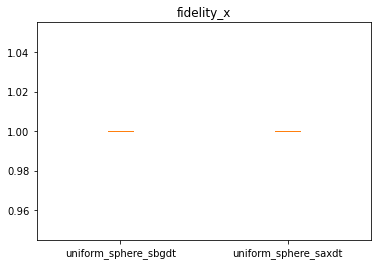

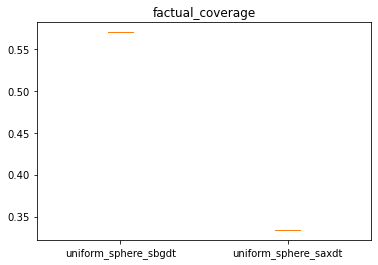

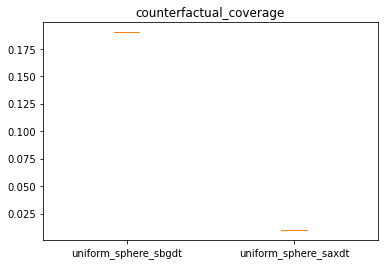

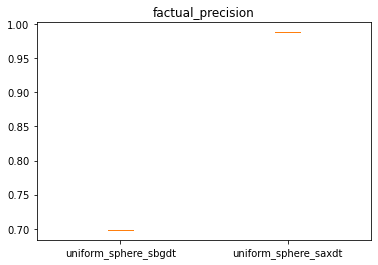

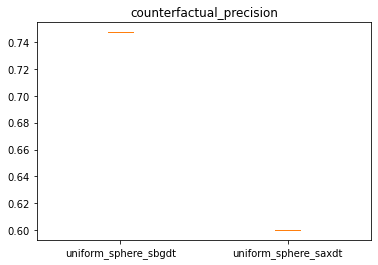

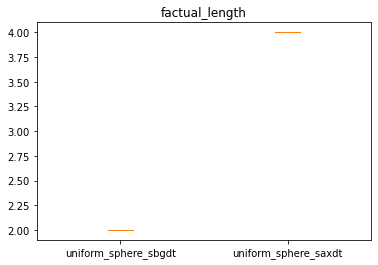

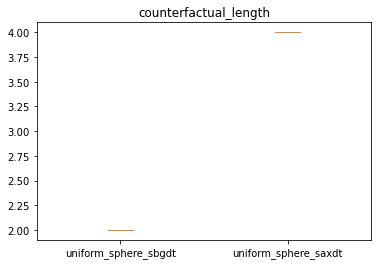

CPU times: user 21min 32s, sys: 9.9 s, total: 21min 42s
Wall time: 7min 25s


In [6]:
%%time
out = multiple_tests(
        X_exp_test,
        blackbox,
        encoder,
        decoder,
        neighborhood_list=neighborhood_list,
        neighborhood_kwargs_list=neighborhood_kwargs_list,
        neighborhood_names=neighborhood_names,
        surrogate_list=surrogate_list,
        surrogate_kwargs_list=surrogate_kwargs_list,
        surrogate_names=surrogate_names,
        file_path=file_path,
        random_state=random_state,
        n_instances_to_explain=1,
        verbose=True,
        simple_dump=[False, True],
        boxplots=True,
        labels=["Robusta", "Arabica"]
    )